In [1]:
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score

import networkx as nx
# from graphviz import Graph, Digraph

In [74]:
def preset_decision(input_vector): # dim(IV) = 3 -> [L, F. R]
    if np.linalg.norm(input_vector) <= 2: # sqrt(2)=1.414
        return [0, 0, 0, 1]
    if input_vector[1]>0 and input_vector[0]==0 and input_vector[2]==0:
        return [1, 0, 0, 0]

    if input_vector[0] > 0 and input_vector[1] > 0:
        ratio = input_vector[1] / (input_vector[0] + input_vector[1])
        return [ratio, 0, 1-ratio, 0]
    elif input_vector[2] > 0 and input_vector[1] > 0:
        ratio = input_vector[1] / (input_vector[2] + input_vector[1])
        return [ratio, 1-ratio, 0, 0]
    
    else:
        return [0.25, 0.25, 0.25, 0.25]


In [79]:
def input_convert(vector):
    vect_L = -min(vector[0], 0)
    vect_R = max(0, vector[0])
    return np.array([vect_L, vector[1], vect_R])

def relative_vector(vector, target):
    return np.array(vector) - np.array(steve)

def update_position(coord_history, target, NN):
    vector = relative_vector(coord_history[-1], target)
    converted_vector = input_convert(vector)
    _, args = NN.feed_forward([converted_vector])
    decisions_in_order = args[0][::-1]
    
    for decision in decisions_in_order:
        if decision == 3:
            break
        
        else:
            action = decision_dict[decision]
            provisional_new_pos = np.array(coord_history[-1]) + action
            if list(provisional_new_pos) not in coord_history:
                coord_history.append(list(provisional_new_pos))

        return decision, coord_history
    return decision, coord_history


In [127]:
class Network:
    def __init__(self, NN_shape, max_param_value=5):
        self.NN_shape = NN_shape
        self._max_param_value = max_param_value + 1

        self._initialise_parameters()
        self._build_network()
        
    def reset(self):
        self._initialise_parameters()
        self._build_network()

    def _initialise_parameters(self):
        self._weight_input_hidden_size = self.NN_shape[0] * self.NN_shape[1]
        self._bias_hidden_size = self.NN_shape[1]
        self._weight_hidden_output_size = self.NN_shape[1] * self.NN_shape[2]
        self._bias_output_size = self.NN_shape[2]

        self._full_parameter_size = self._weight_input_hidden_size + self._bias_hidden_size + self._weight_hidden_output_size + self._bias_output_size
        
        self._parameters = np.random.randint(low=0, high=self._max_param_value, size=(self._full_parameter_size,))
    
    def _build_network(self):
        self.weight_input_hidden = self._parameters[:self._weight_input_hidden_size].reshape((self.NN_shape[0], self.NN_shape[1]))
        self.bias_hidden = self._parameters[self._weight_input_hidden_size: self._weight_input_hidden_size+self._bias_hidden_size].reshape((self.NN_shape[1],))
        self.weight_hidden_output = self._parameters[self._weight_input_hidden_size+self._bias_hidden_size:self._weight_input_hidden_size+self._bias_hidden_size+self._weight_hidden_output_size].reshape((self.NN_shape[1], self.NN_shape[2]))
        self.bias_output = self._parameters[self._weight_input_hidden_size+self._bias_hidden_size+self._weight_hidden_output_size:].reshape((self.NN_shape[2],))

    @staticmethod
    def _calc_mse(x, y):
        return np.mean((x-y)**2)

    @staticmethod
    def _calc_dice(x, y):
        return f1_score(x, y, average='micro')

    def feed_forward(self, input_values):
        self.input = np.array(input_values)
        self.hidden = np.dot(self.input, self.weight_input_hidden) + self.bias_hidden
        self.output = np.dot(self.hidden, self.weight_hidden_output) + self.bias_output
        self.output_normalised = self.output / np.linalg.norm(self.output, axis=1)[:, np.newaxis]

        self.decision = np.argmax(self.output_normalised, axis=1)
        return self.decision, self.output.argsort()

    def train_montecarlo(self, input_data, ground_truth, *, max_iter=10000):
        mse, dice = [], []
        _, _ = self.feed_forward(input_values=input_data)
        curr_mse = self._calc_mse(self.output_normalised, ground_truth)
        curr_dice = self._calc_dice(self.decision, np.argmax(ground_truth, axis=1))
        mse.append(curr_mse)
        dice.append(curr_dice)

        self._parameters_backup = np.copy(self._parameters)        
        self._parameters[np.random.randint(self._full_parameter_size)] = np.random.randint(low=0, high=self._max_param_value)
        self._build_network()

        for curr_iter in tqdm(range(1, max_iter)):
            _, _ = self.feed_forward(input_values=input_data)
            curr_mse = self._calc_mse(self.output_normalised, ground_truth)
            curr_dice = self._calc_dice(self.decision, np.argmax(ground_truth, axis=1))

            if curr_mse < np.min(mse):
                self._parameters_backup = np.copy(self._parameters)
                mse.append(curr_mse)
                dice.append(curr_dice)
                self._parameters[np.random.randint(self._full_parameter_size)] = np.random.randint(low=1, high=self._max_param_value)
                self._build_network()
            else:
                mse.append(mse[-1])
                dice.append(dice[-1])
                self._parameters = np.copy(self._parameters_backup)
                self._parameters[np.random.randint(self._full_parameter_size)] = np.random.randint(low=1, high=self._max_param_value)
                self._build_network()
            
        return(mse, dice)

In [119]:
decision_dict = dict([
    (0, np.array([0, -1])),
    (1, np.array([-1, 0])),
    (2, np.array([1, 0])),
    (3, 'Explode'),
])

## Neural network specification, building and training

In [136]:
my_network = Network((3, 20, 4), max_param_value=20)
train_size = 2000

100%|██████████| 1999/1999 [00:02<00:00, 704.76it/s]


(0.0, 1.2)

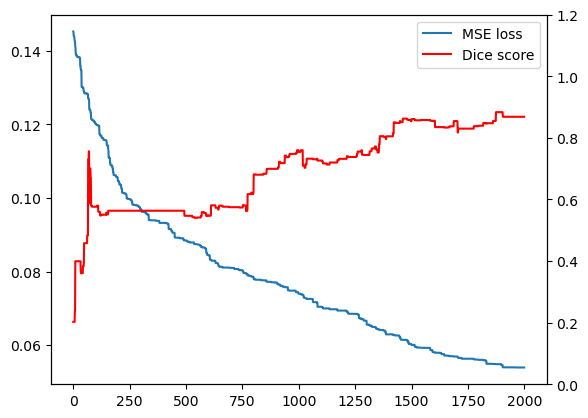

In [140]:
# Re-train network (comment following line if continue training)
my_network.reset()

train_lateral = np.random.normal(loc=0, scale=10, size=train_size).astype(int)
train_y = np.abs(np.random.normal(loc=0, scale=10, size=train_size)).astype(int)
train_L = -np.clip(train_lateral, -np.inf, 0).astype(int)
train_R = np.clip(train_lateral, 0, np.inf).astype(int)

train_inputs = np.array(list(zip(train_L, train_y, train_R)))
# train_decisions = np.array([preset_decision(vector) for vector in train_inputs])
train_decision_matrix = np.array([preset_decision(vector) for vector in train_inputs])

mse, dice = my_network.train_montecarlo(train_inputs, train_decision_matrix, max_iter=2000)

fig, ax = plt.subplots()
ax2 = ax.twinx()
m_plot = ax.plot(mse, label="MSE loss")
d_plot = ax2.plot(dice, c='r', label="Dice score")

leg = m_plot + d_plot
labs = [l.get_label() for l in leg]
ax.legend(leg, labs)

ax.set_yscale('linear')
ax.set_xscale('linear')
ax2.set_xscale('linear')
ax2.set_ylim([0, 1.2])



In [138]:
print(my_network.weight_input_hidden)
print(my_network.bias_hidden)
print(my_network.weight_hidden_output)
print(my_network.bias_output)

[[ 1 19 16 19  2 19  2  1 19  1  1  0  1 19  6  2  2  1  3  3]
 [18  1  3  1  1  1  8  1  1 14  2  0 20  1  1  2  1 16  1  2]
 [ 1  1  1  4  3  1  1 19  1  3 19 20  8  5 18 20  3  1  2  3]]
[ 1  5  3  2  2  3  1  1  2  2  1  1  3  2  1  1 18  3  6 20]
[[20  3  1  1]
 [ 4  1 20  1]
 [ 1  1  6  1]
 [ 1  1 13  2]
 [ 2  5 11  3]
 [ 4  1 20  2]
 [17  3  2  1]
 [ 1 19  2  1]
 [ 6  2 18  1]
 [18  0  0  2]
 [ 2 20  1  0]
 [ 1 20  1  1]
 [20  1  1  2]
 [ 2  1 20  1]
 [ 1 13  1  5]
 [ 2 16  1  1]
 [ 2  1  1 18]
 [18  3  1  1]
 [17  3  3  5]
 [ 5  2  1 11]]
[ 1  8  0 20]


## Demonstration run

Plot legend:  
Green dot = starting point  
Red dot = Steve

[[-2, 15], [-2, 14], [-2, 13], [-2, 12], [-2, 11], [-2, 10], [-2, 9], [-2, 8], [-2, 7], [-1, 7], [-1, 6], [0, 6], [0, 5], [1, 5], [1, 4], [2, 4], [2, 3], [3, 3], [3, 2], [3, 1], [4, 1], [4, 0]]
22 22


(-5.0, 20.0)

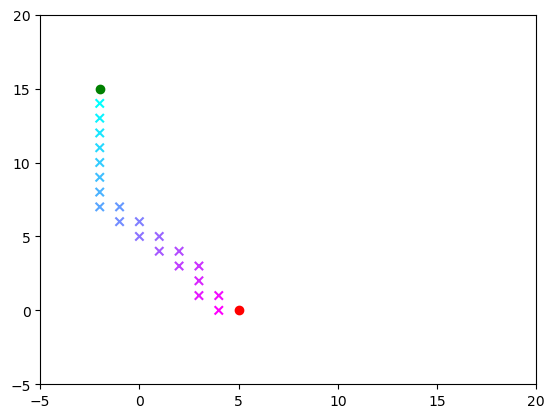

In [139]:
steve = [5, 0]
creeper = [-2, 15]

coords_hist = [creeper]
step, max_step = 0, 100

decision = None
for step in range(max_step):
    decision, coords_hist = update_position(coords_hist, steve, my_network)
    if decision == 3:
        break

print(coords_hist[:-1])
print(step, len(coords_hist[:-1]))
coords_hist_stack = np.stack(coords_hist)
        
fig, ax = plt.subplots()
# ax.axis('equal')
ax.scatter(coords_hist_stack[0, 0], coords_hist_stack[0, 1], c='g', marker='o')
ax.scatter(steve[0], steve[1], c='r', marker='o')
ax.scatter(coords_hist_stack[1:-1, 0], coords_hist_stack[1:-1, 1], cmap='cool', c=range(1, len(coords_hist_stack)-1), marker='x')

ax.set_xlim([-5, 20])
ax.set_ylim([-5, 20])